In [25]:
import tensorflow as tf
import cv2
import numpy as np
import scipy.io as sc
from glob import glob
import keras
from keras import layers

In [26]:
!unzip with_mask.zip;
!unzip without_mask.zip;

Archive:  with_mask.zip
   creating: with_mask/
  inflating: with_mask/augmented_image_218.jpg  
   creating: __MACOSX/
   creating: __MACOSX/with_mask/
  inflating: __MACOSX/with_mask/._augmented_image_218.jpg  
  inflating: with_mask/augmented_image_19.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_19.jpg  
  inflating: with_mask/augmented_image_31.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_31.jpg  
  inflating: with_mask/augmented_image_25.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_25.jpg  
  inflating: with_mask/augmented_image_230.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_230.jpg  
  inflating: with_mask/419-with-mask.jpg  
  inflating: __MACOSX/with_mask/._419-with-mask.jpg  
  inflating: with_mask/330-with-mask.jpg  
  inflating: __MACOSX/with_mask/._330-with-mask.jpg  
  inflating: with_mask/260-with-mask.jpg  
  inflating: __MACOSX/with_mask/._260-with-mask.jpg  
  inflating: with_mask/27-with-mask.jpg  
  inflating: __MACOSX/wi

  inflating: with_mask/augmented_image_196.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_196.jpg  
  inflating: with_mask/augmented_image_182.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_182.jpg  
  inflating: with_mask/augmented_image_169.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_169.jpg  
  inflating: with_mask/augmented_image_155.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_155.jpg  
  inflating: with_mask/augmented_image_4.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_4.jpg  
  inflating: with_mask/augmented_image_141.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_141.jpg  
  inflating: with_mask/369-with-mask.jpg  
  inflating: __MACOSX/with_mask/._369-with-mask.jpg  
  inflating: with_mask/239-with-mask.jpg  
  inflating: __MACOSX/with_mask/._239-with-mask.jpg  
  inflating: with_mask/284-with-mask.jpg  
  inflating: __MACOSX/with_mask/._284-with-mask.jpg  
  inflating: with_mask/440-with-mask.jpg  
  inflating: __M

  inflating: __MACOSX/with_mask/._augmented_image_84.jpg  
  inflating: with_mask/augmented_image_90.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_90.jpg  
  inflating: with_mask/augmented_image_285.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_285.jpg  
  inflating: with_mask/317-with-mask.jpg  
  inflating: __MACOSX/with_mask/._317-with-mask.jpg  
  inflating: with_mask/augmented_image_252.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_252.jpg  
  inflating: with_mask/augmented_image_47.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_47.jpg  
  inflating: with_mask/augmented_image_53.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_53.jpg  
  inflating: with_mask/augmented_image_246.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_246.jpg  
  inflating: with_mask/augmented_image_79.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_79.jpg  
  inflating: with_mask/augmented_image_45.jpg  
  inflating: __MACOSX/with_mask/._augment

  inflating: __MACOSX/with_mask/._394-with-mask.jpg  
  inflating: with_mask/175-with-mask.jpg  
  inflating: __MACOSX/with_mask/._175-with-mask.jpg  
  inflating: with_mask/400-with-mask.jpg  
  inflating: __MACOSX/with_mask/._400-with-mask.jpg  
  inflating: with_mask/augmented_image_134.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_134.jpg  
  inflating: with_mask/augmented_image_120.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_120.jpg  
  inflating: with_mask/augmented_image_108.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_108.jpg  
  inflating: with_mask/10-with-mask.jpg  
  inflating: __MACOSX/with_mask/._10-with-mask.jpg  
  inflating: with_mask/307-with-mask.jpg  
  inflating: __MACOSX/with_mask/._307-with-mask.jpg  
  inflating: with_mask/257-with-mask.jpg  
  inflating: __MACOSX/with_mask/._257-with-mask.jpg  
  inflating: with_mask/439-with-mask.jpg  
  inflating: __MACOSX/with_mask/._439-with-mask.jpg  
  inflating: with_mask/240-with-mask.jp

  inflating: __MACOSX/with_mask/._167-with-mask.jpg  
  inflating: with_mask/augmented_image_107.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_107.jpg  
  inflating: with_mask/augmented_image_113.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_113.jpg  
  inflating: with_mask/augmented_image_305.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_305.jpg  
  inflating: with_mask/augmented_image_311.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_311.jpg  
  inflating: with_mask/86-with-mask.jpg  
  inflating: __MACOSX/with_mask/._86-with-mask.jpg  
  inflating: with_mask/391-with-mask.jpg  
  inflating: __MACOSX/with_mask/._391-with-mask.jpg  
  inflating: with_mask/170-with-mask.jpg  
  inflating: __MACOSX/with_mask/._170-with-mask.jpg  
  inflating: with_mask/405-with-mask.jpg  
  inflating: __MACOSX/with_mask/._405-with-mask.jpg  
  inflating: with_mask/311-with-mask.jpg  
  inflating: __MACOSX/with_mask/._311-with-mask.jpg  
  inflating: with_mask/241-

  inflating: with_mask/62-with-mask.jpg  
  inflating: __MACOSX/with_mask/._62-with-mask.jpg  
  inflating: with_mask/225-with-mask.jpg  
  inflating: __MACOSX/with_mask/._225-with-mask.jpg  
  inflating: with_mask/augmented_image_114.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_114.jpg  
  inflating: with_mask/375-with-mask.jpg  
  inflating: __MACOSX/with_mask/._375-with-mask.jpg  
  inflating: with_mask/107-with-mask.jpg  
  inflating: __MACOSX/with_mask/._107-with-mask.jpg  
  inflating: with_mask/472-with-mask.jpg  
  inflating: __MACOSX/with_mask/._472-with-mask.jpg  
  inflating: with_mask/augmented_image_289.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_289.jpg  
  inflating: with_mask/augmented_image_88.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_88.jpg  
  inflating: with_mask/augmented_image_63.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_63.jpg  
  inflating: with_mask/110-with-mask.jpg  
  inflating: __MACOSX/with_mask/._110-with

  inflating: with_mask/425-with-mask.jpg  
  inflating: __MACOSX/with_mask/._425-with-mask.jpg  
  inflating: with_mask/150-with-mask.jpg  
  inflating: __MACOSX/with_mask/._150-with-mask.jpg  
  inflating: with_mask/432-with-mask.jpg  
  inflating: __MACOSX/with_mask/._432-with-mask.jpg  
  inflating: with_mask/147-with-mask.jpg  
  inflating: __MACOSX/with_mask/._147-with-mask.jpg  
  inflating: with_mask/169-with-mask.jpg  
  inflating: __MACOSX/with_mask/._169-with-mask.jpg  
  inflating: with_mask/augmented_image_161.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_161.jpg  
  inflating: with_mask/augmented_image_175.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_175.jpg  
  inflating: with_mask/335-with-mask.jpg  
  inflating: __MACOSX/with_mask/._335-with-mask.jpg  
  inflating: with_mask/augmented_image_149.jpg  
  inflating: __MACOSX/with_mask/._augmented_image_149.jpg  
  inflating: with_mask/272-with-mask.jpg  
  inflating: __MACOSX/with_mask/._272-with-mask.

  inflating: without_mask/augmented_image_32.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_32.jpg  
  inflating: without_mask/augmented_image_227.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_227.jpg  
  inflating: without_mask/149.jpg    
  inflating: __MACOSX/without_mask/._149.jpg  
  inflating: without_mask/175.jpg    
  inflating: __MACOSX/without_mask/._175.jpg  
  inflating: without_mask/161.jpg    
  inflating: __MACOSX/without_mask/._161.jpg  
  inflating: without_mask/388.jpg    
  inflating: __MACOSX/without_mask/._388.jpg  
  inflating: without_mask/439.jpg    
  inflating: __MACOSX/without_mask/._439.jpg  
  inflating: without_mask/411.jpg    
  inflating: __MACOSX/without_mask/._411.jpg  
  inflating: without_mask/405.jpg    
  inflating: __MACOSX/without_mask/._405.jpg  
  inflating: without_mask/363.jpg    
  inflating: __MACOSX/without_mask/._363.jpg  
  inflating: without_mask/augmented_image_179.jpg  
  inflating: __MACOSX/without_mask/._aug

  inflating: without_mask/augmented_image_234.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_234.jpg  
  inflating: without_mask/augmented_image_21.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_21.jpg  
  inflating: without_mask/9.jpg      
  inflating: __MACOSX/without_mask/._9.jpg  
  inflating: without_mask/augmented_image_35.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_35.jpg  
  inflating: without_mask/augmented_image_220.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_220.jpg  
  inflating: without_mask/14.jpg     
  inflating: __MACOSX/without_mask/._14.jpg  
  inflating: without_mask/augmented_image_52.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_52.jpg  
  inflating: without_mask/augmented_image_253.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_253.jpg  
  inflating: without_mask/28.jpg     
  inflating: __MACOSX/without_mask/._28.jpg  
  inflating: without_mask/129.jpg    
  inflating: __MACOSX/witho

  inflating: without_mask/306.jpg    
  inflating: __MACOSX/without_mask/._306.jpg  
  inflating: without_mask/460.jpg    
  inflating: __MACOSX/without_mask/._460.jpg  
  inflating: without_mask/312.jpg    
  inflating: __MACOSX/without_mask/._312.jpg  
  inflating: without_mask/448.jpg    
  inflating: __MACOSX/without_mask/._448.jpg  
  inflating: without_mask/augmented_image_134.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_134.jpg  
  inflating: without_mask/augmented_image_120.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_120.jpg  
  inflating: without_mask/299.jpg    
  inflating: __MACOSX/without_mask/._299.jpg  
  inflating: without_mask/266.jpg    
  inflating: __MACOSX/without_mask/._266.jpg  
  inflating: without_mask/267.jpg    
  inflating: __MACOSX/without_mask/._267.jpg  
  inflating: without_mask/298.jpg    
  inflating: __MACOSX/without_mask/._298.jpg  
  inflating: without_mask/augmented_image_109.jpg  
  inflating: __MACOSX/without_mask/._a

  inflating: without_mask/297.jpg    
  inflating: __MACOSX/without_mask/._297.jpg  
  inflating: without_mask/augmented_image_112.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_112.jpg  
  inflating: without_mask/augmented_image_106.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_106.jpg  
  inflating: without_mask/283.jpg    
  inflating: __MACOSX/without_mask/._283.jpg  
  inflating: without_mask/446.jpg    
  inflating: __MACOSX/without_mask/._446.jpg  
  inflating: without_mask/452.jpg    
  inflating: __MACOSX/without_mask/._452.jpg  
  inflating: without_mask/334.jpg    
  inflating: __MACOSX/without_mask/._334.jpg  
  inflating: without_mask/308.jpg    
  inflating: __MACOSX/without_mask/._308.jpg  
  inflating: without_mask/122.jpg    
  inflating: __MACOSX/without_mask/._122.jpg  
  inflating: without_mask/136.jpg    
  inflating: __MACOSX/without_mask/._136.jpg  
  inflating: without_mask/augmented_image_71.jpg  
  inflating: __MACOSX/without_mask/._au

  inflating: __MACOSX/without_mask/._augmented_image_238.jpg  
  inflating: without_mask/55.jpg     
  inflating: __MACOSX/without_mask/._55.jpg  
  inflating: without_mask/7.jpg      
  inflating: __MACOSX/without_mask/._7.jpg  
  inflating: without_mask/69.jpg     
  inflating: __MACOSX/without_mask/._69.jpg  
  inflating: without_mask/197.jpg    
  inflating: __MACOSX/without_mask/._197.jpg  
  inflating: without_mask/183.jpg    
  inflating: __MACOSX/without_mask/._183.jpg  
  inflating: without_mask/augmented_image_13.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_13.jpg  
  inflating: without_mask/augmented_image_206.jpg  
  inflating: __MACOSX/without_mask/._augmented_image_206.jpg  
  inflating: without_mask/96.jpg     
  inflating: __MACOSX/without_mask/._96.jpg  
  inflating: without_mask/168.jpg    
  inflating: __MACOSX/without_mask/._168.jpg  
  inflating: without_mask/154.jpg    
  inflating: __MACOSX/without_mask/._154.jpg  
  inflating: without_mask/140.jpg 

In [27]:
!mkdir train;
!mv with_mask train;
!mv without_mask train;

### Set Up Data

In [28]:
from sklearn.model_selection import train_test_split
with_mask = glob('train/with_mask/*.jpg')
without_mask = glob('train/without_mask/*.jpg')
with_mask_train, with_mask_test = train_test_split(with_mask, test_size=0.1)
without_mask_train, without_mask_test = train_test_split(without_mask, test_size=0.1)


#moves the validation files out of the train directory and over to the val directory.

!mkdir val

!mkdir val/with_mask
files = ' '.join(with_mask_test)
!mv $files val/with_mask 

!mkdir val/without_mask
files = ' '.join(without_mask_test)
!mv $files val/without_mask

!rm -rf train/.ipynb_checkpoints
!rm -rf val/.ipynb_checkpoints


Found 1238 files belonging to 2 classes.
Found 138 files belonging to 2 classes.


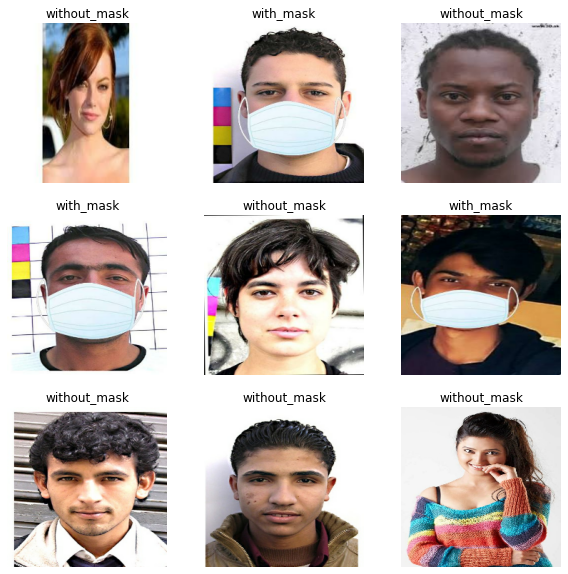

In [29]:
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory('./train',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory('./val',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10)) 
for images, labels in train_dataset.take(1): #9 examples of the training dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Augment data for training

In [74]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(####
    rescale = 1./255.,
#     rotation_range=90,
#     zoom_range=[1,2],
#     horizontal_flip=True,
#     fill_mode='nearest' 
)

train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(224,224),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    './val',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1238 images belonging to 2 classes.
Found 138 images belonging to 2 classes.


### Configure dataset for performance

In [31]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### Modify network

In [32]:
model = keras.applications.MobileNetV2() #pre-trained, 14MB, smallest available model
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [33]:
#creates base model from pretrained network trained on ImageNet dataset
#Here by setting include_top to false we exclude the classification layers at the end of the network
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [75]:
from keras import Model
base_model.trainable = False #freeze the base weights, model has already learned these

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)


In [78]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [77]:
# EPOCHS = 5
# BATCH_SIZE = 10
# STEPS_PER_EPOCH = 5
# VALIDATION_STEPS = 1
# MODEL_FILE = 'filename.model'

hist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 5, epochs = 10)

  
# model.save(MODEL_FILE)

Epoch 1/10
5/5 [==============================] - 5s 935ms/step - loss: 0.5460 - acc: 0.8200 - val_loss: 0.3675 - val_acc: 0.9928
Epoch 2/10
5/5 [==============================] - 5s 920ms/step - loss: 0.3496 - acc: 0.9200 - val_loss: 0.3562 - val_acc: 0.8188
Epoch 3/10
5/5 [==============================] - 5s 910ms/step - loss: 0.7396 - acc: 0.8000 - val_loss: 0.3832 - val_acc: 0.9855
Epoch 4/10
5/5 [==============================] - 5s 927ms/step - loss: 0.3733 - acc: 0.9000 - val_loss: 0.3536 - val_acc: 0.9565
Epoch 5/10
5/5 [==============================] - 5s 912ms/step - loss: 0.5615 - acc: 0.9000 - val_loss: 0.3724 - val_acc: 0.9928
Epoch 6/10
5/5 [==============================] - 5s 901ms/step - loss: 0.6078 - acc: 0.9600 - val_loss: 0.3701 - val_acc: 0.9783
Epoch 7/10
5/5 [==============================] - 5s 921ms/step - loss: 0.7566 - acc: 0.9200 - val_loss: 0.3793 - val_acc: 0.9855
Epoch 8/10
5/5 [==============================] - 5s 938ms/step - loss: 0.3843 - acc: 0.90